In [53]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from adjustText import adjust_text

import nfl_data_py as nfl

In [54]:
pd.options.display.max_columns = None

In [55]:
years = range(2001, 2023)

In [56]:
depth_charts = nfl.import_depth_charts(years)

In [57]:
depth_charts = depth_charts[['season', 'week', 'club_code', 'full_name', 'game_type', 'depth_team', 'formation', 'position']]

In [58]:
# Filter for week 1
week1_data = depth_charts[(depth_charts['week'] == 1.0) & (depth_charts['depth_team'] == '1')]

# Get unique seasons
seasons = week1_data['season'].unique()

In [59]:
# Import necessary libraries
import pandas as pd

# Filter for week 1
week1_data = depth_charts[depth_charts['week'] == 1]

# Get unique seasons
seasons = week1_data['season'].unique()

# Initialize a list to store continuity metrics
continuity_metrics = []

# Iterate through the unique seasons except the first one
for season in seasons[1:]:
    previous_season = season - 1

    # Get the players for the current season and previous season
    current_season_players = week1_data[(week1_data['season'] == season)]
    previous_season_players = week1_data[(
        week1_data['season'] == previous_season)]

    # Iterate through the unique club codes
    for club in current_season_players['club_code'].unique():
        for formation in ['Offense', 'Defense']:
            current_club_players = set(current_season_players[(current_season_players['club_code'] == club) & (
                current_season_players['formation'] == formation)]['full_name'])
            previous_club_players = set(previous_season_players[(previous_season_players['club_code'] == club) & (
                previous_season_players['formation'] == formation)]['full_name'])

            # Find common players and calculate the continuity metric
            if previous_club_players:
                common_players = len(
                    current_club_players.intersection(previous_club_players))
                continuity_metric = common_players / \
                    len(previous_club_players) * 100
            else:
                continuity_metric = 0

            # Append the continuity metric
            continuity_metrics.append(
                ( season, club, formation, continuity_metric))

# Convert the continuity metrics to a DataFrame
continuity_df = pd.DataFrame(continuity_metrics, columns=[
                              'Season', 'Club', 'Formation', 'Continuity'])

In [60]:
continuity_df

,Season,Club,Formation,Continuity
0,2002.0,MIN,Offense,70.000000
1,2002.0,MIN,Defense,38.095238
2,2002.0,NYJ,Offense,75.000000
3,2002.0,NYJ,Defense,50.000000
4,2002.0,PHI,Offense,88.888889
...,...,...,...,...
1335,2022.0,JAX,Defense,60.000000
1336,2022.0,CLE,Offense,60.000000
1337,2022.0,CLE,Defense,60.000000
1338,2022.0,HOU,Offense,43.478261


In [61]:
columns = ['season', 'posteam', 'defteam', 'season_type', 'play', 'epa']

In [62]:
df = nfl.import_pbp_data(years, columns=columns, cache=True, alt_path='../cache')

2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [63]:
# Calculate offense 0
offense_epa = df[df['posteam'].notna() & (df['season_type'] == 'REG')].groupby(['season', 'posteam'])['epa'].sum(
) / df[df['posteam'].notna() & (df['season_type'] == 'REG')].groupby(['season', 'posteam'])['play'].count()
offense_epa_df = offense_epa.reset_index().rename(
    columns={'epa': '0', 'posteam': 'Club', 'season': 'Season'})
offense_epa_df['Formation'] = 'Offense'

# Calculate defense 0
defense_epa = df[df['defteam'].notna() & (df['season_type'] == 'REG')].groupby(['season', 'defteam'])['epa'].sum(
) / df[df['defteam'].notna() & (df['season_type'] == 'REG')].groupby(['season', 'defteam'])['play'].count()
defense_epa_df = defense_epa.reset_index().rename(
    columns={'epa': '0', 'defteam': 'Club', 'season': 'Season'})
defense_epa_df['Formation'] = 'Defense'

# Concatenate offense and defense DataFrames
epa_per_play_df = pd.concat(
    [offense_epa_df, defense_epa_df], ignore_index=True)

# Merge with continuity DataFrame (replace continuity_df with your DataFrame name)
merged_df = pd.merge(continuity_df, epa_per_play_df, on=[
                     'Season', 'Club', 'Formation'], how='outer')



In [64]:
# Assuming you have the epa_per_play_df and continuity_df DataFrames

# Rename the column '0' to 'EPA per Play'
epa_per_play_df = epa_per_play_df.rename(columns={0: 'EPA per Play'})

# Merge the two DataFrames
merged_df = pd.merge(continuity_df, epa_per_play_df, on=[
                     'Season', 'Club', 'Formation'], how='left')

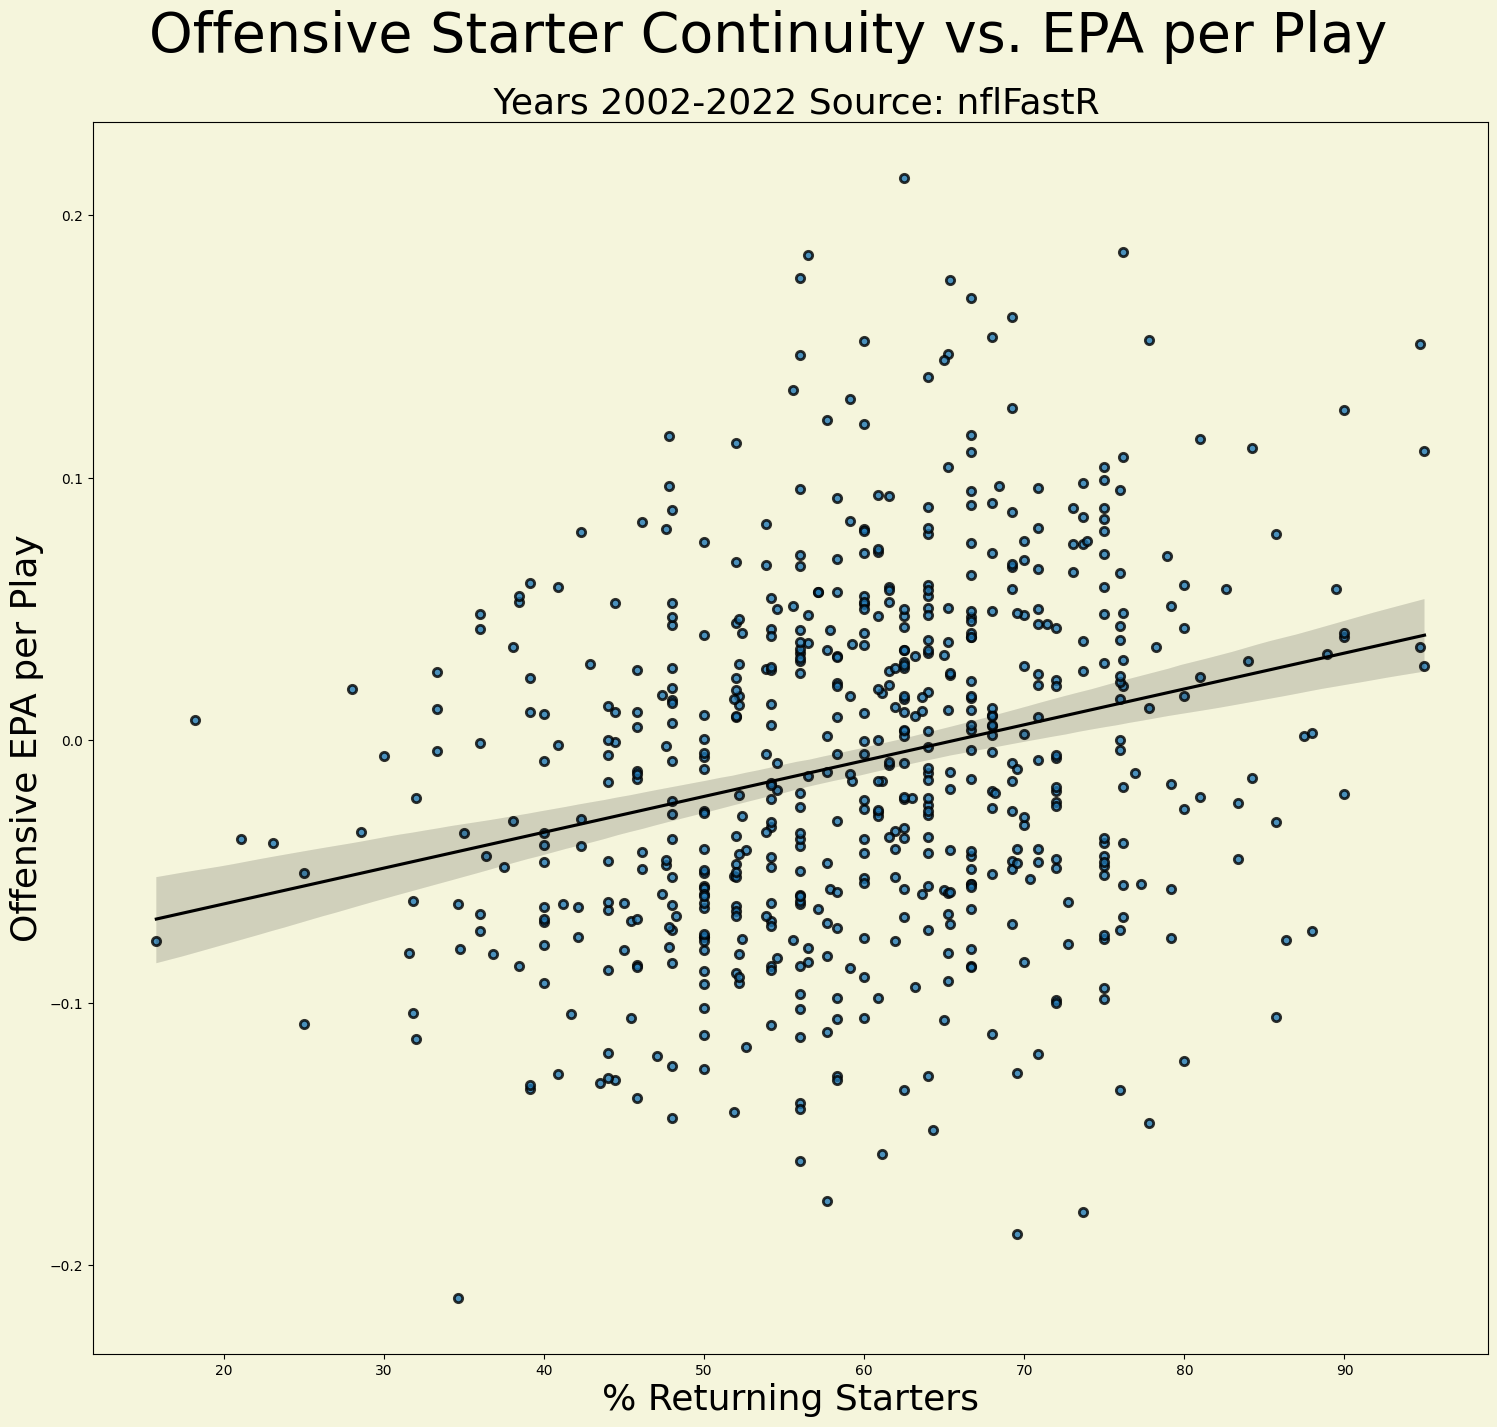

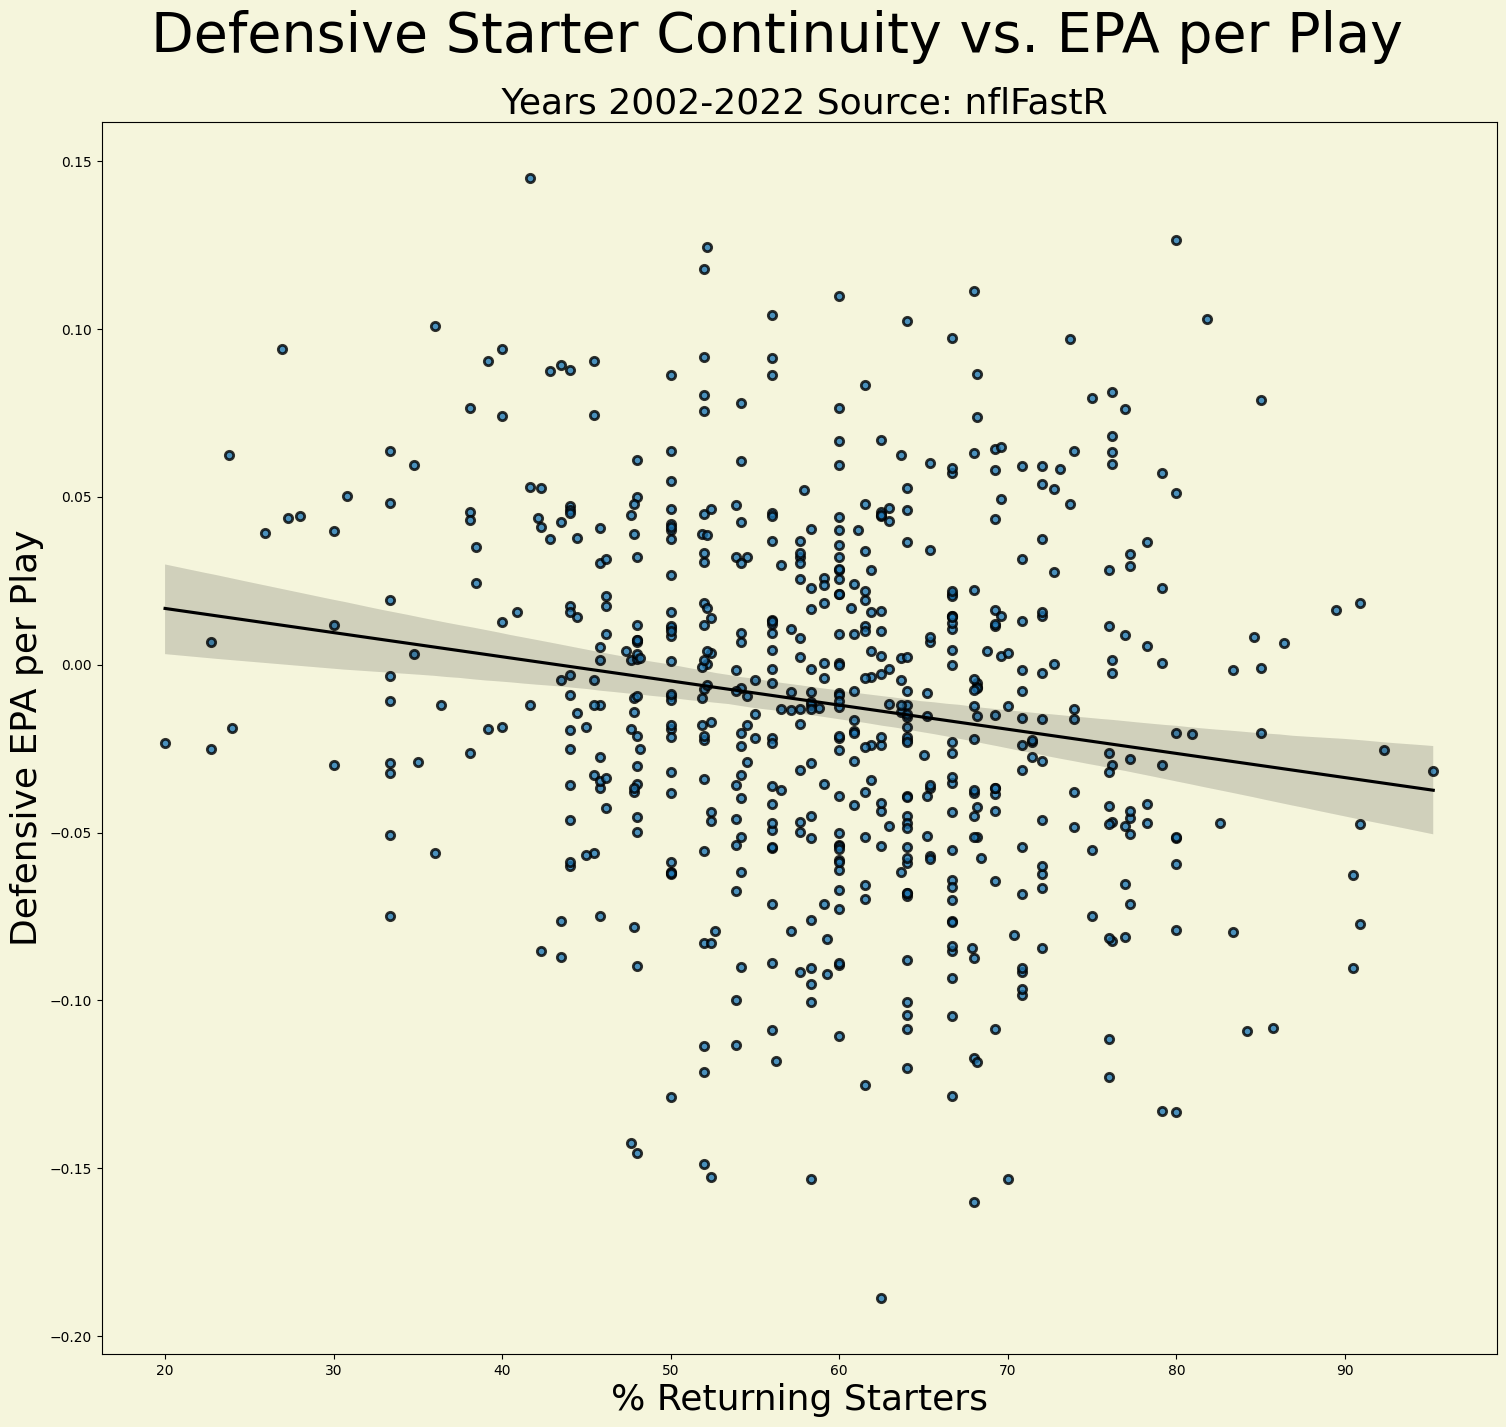

In [65]:
import seaborn as sns

# Drop rows where continuity equals to 0
merged_df = merged_df[merged_df['Continuity'] != 0]

# Separate data for Offense and Defense
offense_data = merged_df[(merged_df['Formation'] == 'Offense')]
defense_data = merged_df[(merged_df['Formation'] == 'Defense')]

# Define a function to create the plot


def create_plot(data, title_suffix):
    fig, ax = plt.subplots(figsize=(18, 16))

    fig.patch.set_facecolor('beige')
    ax.set_facecolor('beige')

    # Seaborn scatter plot with a best fit line
    sns.regplot(x='Continuity', y='EPA per Play', data=data, scatter_kws={
                'edgecolor': 'black', 'linewidth': 2}, ax=ax, line_kws={'color': 'black'})

    # Titles and labels
    plt.suptitle(f"{title_suffix}ive Starter Continuity vs. EPA per Play",
                 fontsize=40, y=0.95, ha='center')
    plt.title(" Years 2002-2022 Source: nflFastR",
              fontsize=26, y=1.0, ha='center')
    plt.xlabel('% Returning Starters', fontsize=26)
    plt.ylabel(f'{title_suffix}ive EPA per Play', fontsize=26)

    # Save the plot
    plt.savefig(f'{title_suffix}_continuity_vs_epa.png',
                dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


# Create plots for Offense and Defense
create_plot(offense_data, 'Offens')
create_plot(defense_data, 'Defens')